In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, max_error

In [2]:
%matplotlib inline
sns.set()

## Load data and transformers back

In [3]:
import pickle
with open('../count-power-transformer.pkl', 'rb') as inf:
    pt = pickle.load(inf)
data = pd.read_pickle('../data-dummies-and-date.pkl.xz')
print(pt, pt.lambdas_)
data.head()

PowerTransformer(copy=True, method='box-cox', standardize=False) [0.31567024]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,season_4,weather_1,weather_2,weather_3,weather_4,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,0,1,0,0,0,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,0,1,0,0,0,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,0,1,0,0,0,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,0,1,0,0,0,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,0,1,0,0,0,2011,1,1,4,5


### Train a model to fill wind speed

#### Train a random forest regressor

In [4]:
wind_speed_features = [
    "season_1", "season_2", "season_3", "season_4",
    "weather_1", "weather_2", "weather_3", "weather_4",
    "humidity", "temp", "atemp", "year", "month"
]
wind_speed_x = data.loc[data.windspeed != 0, wind_speed_features]
wind_speed_y = data.loc[data.windspeed != 0, 'windspeed']

In [5]:
wind_speed_x_train, wind_speed_x_testing, wind_speed_y_train, wind_speed_y_testing = train_test_split(
    wind_speed_x, wind_speed_y, test_size=0.1, random_state=42
)
wind_speed_x_train.shape, wind_speed_x_testing.shape

((8615, 13), (958, 13))

In [6]:
rfr = RandomForestRegressor()
rfr.fit(wind_speed_x_train, wind_speed_y_train)

f:\venvs\cisco-kaggle\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [7]:
pred = rfr.predict(wind_speed_x_testing)
rmsle = np.sqrt(mean_squared_log_error(pred, wind_speed_y_testing))
rmse = np.sqrt(mean_squared_error(pred, wind_speed_y_testing))
mae = mean_absolute_error(pred, wind_speed_y_testing)
me = max_error(pred, wind_speed_y_testing)
print('RMSLE:', rmsle)
print('RMSE:', rmse)
print('MAE:', mae)
print('Max Error:', me)

RMSLE: 0.34208835555225336
RMSE: 5.487676267046557
MAE: 3.8808122360326704
Max Error: 34.100989999999996


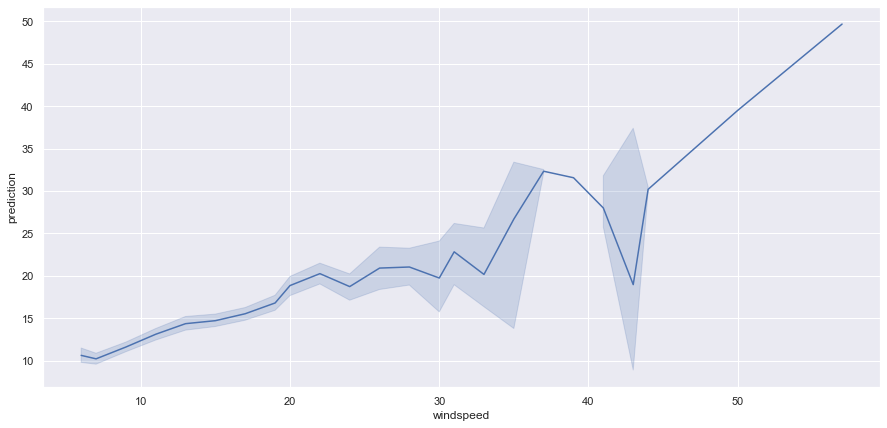

In [8]:
cmp = pd.DataFrame({
    'windspeed': wind_speed_y_testing,
    'prediction': pred
})
sns.lineplot(x='windspeed', y='prediction', data=cmp)
plt.gcf().set_size_inches(15, 7)

#### Fill missing wind speeds

In [9]:
wind_speed_missing = data.loc[data.windspeed == 0, wind_speed_features]
wind_speed_estimation = rfr.predict(wind_speed_missing)
data.loc[data.windspeed == 0, 'windspeed'] = wind_speed_estimation

Text(0.5, 0, 'filled wind speed')

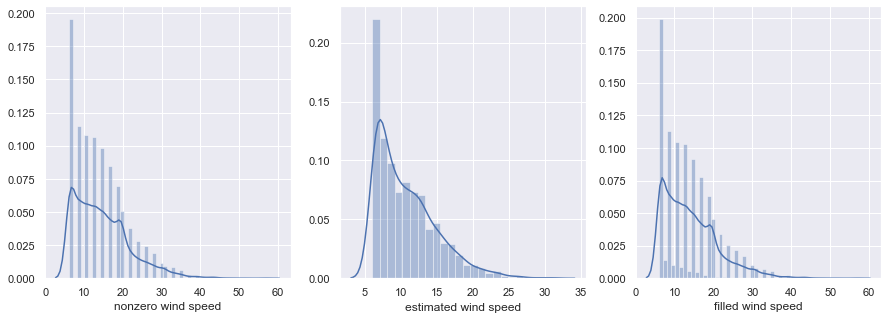

In [10]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.distplot(wind_speed_y, ax=axes[0])
axes[0].set_xlabel('nonzero wind speed')
sns.distplot(wind_speed_estimation, ax=axes[1])
axes[1].set_xlabel('estimated wind speed')
sns.distplot(data.windspeed, ax=axes[2])
axes[2].set_xlabel('filled wind speed')

## Specify features used for training

In [11]:
features = [
    'season_1', 'season_2', 'season_3', 'season_4',
    'weather_1', 'weather_2', 'weather_3', 'weather_4',
    'year', 'month', 'weekday', 'hour',
    'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
]
target = 'count_transformed'

In [12]:
x = data[features]
y = data[target]
count_original = data['count']

## Split sample data into training set and testing set

In [13]:
x_train, x_testing, y_train, _, _, y_testing = train_test_split(
    x, y, count_original,
    test_size=0.25, random_state=42,
)
print(
    'training set:', x_train.shape, y_train.shape,
    '\n',
    'testing set:', x_testing.shape, y_testing.shape,
)

training set: (8164, 18) (8164,) 
 testing set: (2722, 18) (2722,)


## Train models then evaluate the performance

In [14]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']

In [15]:
for model in models:
    model.fit(x_train, y_train)

f:\venvs\cisco-kaggle\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
f:\venvs\cisco-kaggle\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [16]:
rmsle = []
predictions = []

for name, model in zip(model_names, models):
    y_pred = model.predict(x_testing)
    y_pred = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    predictions.append(y_pred)
    rmsle.append(
        np.sqrt(
            mean_squared_log_error(
                y_pred,
                y_testing,
            )
        )
    )

result = pd.DataFrame({
    'Model': model_names,
    'RMSLE': rmsle,
    'Note': 'fill windspeed'
})
result

,Model,RMSLE,Note
0,RandomForestRegressor,0.310463,fill windspeed
1,AdaBoostRegressor,0.631744,fill windspeed
2,BaggingRegressor,0.316238,fill windspeed
3,SVR,0.909996,fill windspeed
4,KNeighborsRegressor,0.740120,fill windspeed


In [17]:
previous_training = pd.read_pickle('../rmsle_dummies_and_date.pkl')

In [18]:
pd.pivot_table(pd.concat([previous_training, result], axis=0), index='Model', columns=['Note'], values=['RMSLE'])

RMSLE               
Note                  dummies and date fill windspeed
Model                                                
AdaBoostRegressor             0.646122       0.631744
BaggingRegressor              0.317036       0.316238
KNeighborsRegressor           0.776564       0.740120
RandomForestRegressor         0.314075       0.310463
SVR                           0.975268       0.909996

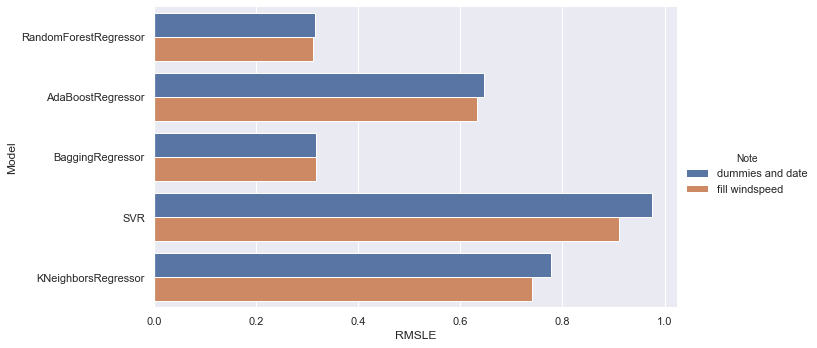

In [19]:
sns.catplot(
    x='RMSLE', y='Model', hue='Note',
    data=pd.concat([previous_training, result], axis=0),
    kind='bar', height=5, aspect=2
)

In [20]:
result.to_pickle('../rmsle_fill_windspeed.pkl')

In [21]:
data.to_pickle('../data-fill-windspeed.pkl.xz')